In [8]:
import jax 
import jax.numpy as jnp
import numpy as np
from jax import jit, vmap
import torch
from scipy.spatial import cKDTree
from scipy.spatial import KDTree
import os
import random
import seaborn as sns

In [9]:
file_path = "../Gradient NN/Data/Full_point_clouds/bevel_gear_1.xyz"  # Update with your file path
points = np.loadtxt(file_path)

In [10]:
from sklearn.neighbors import NearestNeighbors

# Parameters
k_neighbors = 10  # Number of neighbors to use for PCA
point_index = 5  # Index of the point you want to analyze (change this as needed)

# Initialize k-NN model
neighbors = NearestNeighbors(n_neighbors=k_neighbors)
neighbors.fit(points)

# Get the k-nearest neighbors for the chosen point
distances, indices = neighbors.kneighbors([points[point_index]])

# Extract the neighborhood points
neighborhood = points[indices[0]]

# Compute the covariance matrix of the neighborhood
cov_matrix = np.cov(neighborhood.T)

# Perform PCA by calculating eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Print the eigenvalues
print("Eigenvalues of the covariance matrix:", eigenvalues)

# Calculate the geometric properties based on eigenvalues
curvature = eigenvalues[2] / np.sum(eigenvalues)
anisotropy = (eigenvalues[0] - eigenvalues[2]) / eigenvalues[0]
linearity = (eigenvalues[0] - eigenvalues[1]) / eigenvalues[0]
planarity = (eigenvalues[1] - eigenvalues[2]) / eigenvalues[0]
sphericity = eigenvalues[2] / eigenvalues[0]
variation = eigenvalues[0] / (eigenvalues[0] + eigenvalues[2])

# Print the computed properties
print("Curvature:", curvature)
print("Anisotropy:", anisotropy)
print("Linearity:", linearity)
print("Planarity:", planarity)
print("Sphericity:", sphericity)
print("Variation:", variation)


Eigenvalues of the covariance matrix: [0.7030216  0.63823251 0.20900418 0.05290632 0.00743203 0.00148814]
Curvature: 0.12964838140418528
Anisotropy: 0.7027058864421151
Linearity: 0.09215803695896344
Planarity: 0.6105478494831517
Sphericity: 0.2972941135578849
Variation: 0.7708352250650833


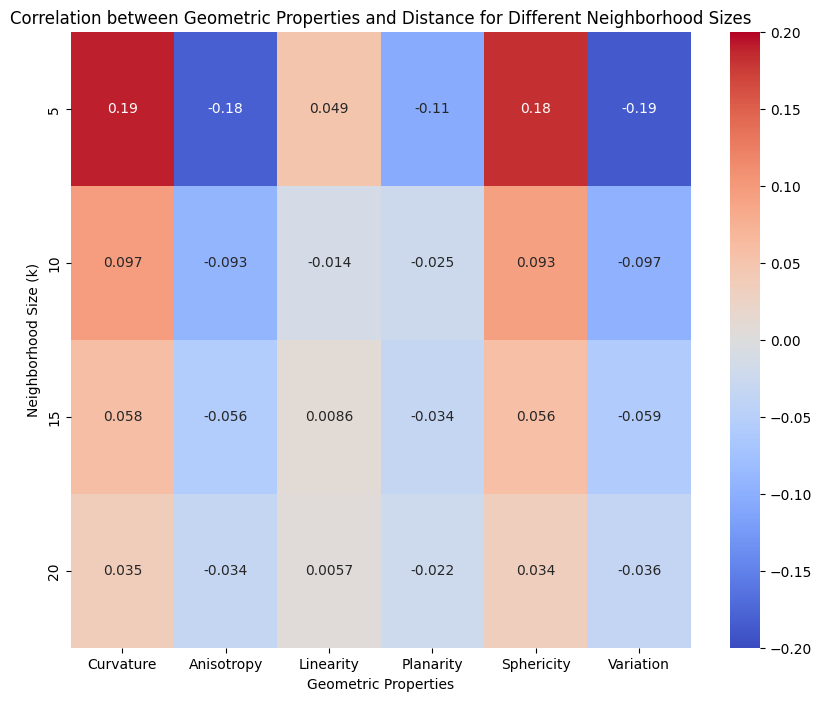

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.stats import pearsonr
import pandas as pd

# Parameters
neighborhood_sizes = [5, 10, 15, 20]  # Different neighborhood sizes to test
file_path = "../Gradient NN/Data/Full_point_clouds/bevel_gear_1.xyz"  # Update with your file path

# Load the point cloud from the .txt file
points = np.loadtxt(file_path)

# Function to calculate the Euclidean distance
def euclidean_distance(p1, p2):
    return np.linalg.norm(p1 - p2)

# Function to compute PCA and geometric properties
def compute_geometric_properties(neighborhood):
    # Compute the covariance matrix
    cov_matrix = np.cov(neighborhood.T)

    # Perform PCA (eigenvalue decomposition)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Sort eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    # Calculate geometric properties
    curvature = eigenvalues[2] / np.sum(eigenvalues)
    anisotropy = (eigenvalues[0] - eigenvalues[2]) / eigenvalues[0]
    linearity = (eigenvalues[0] - eigenvalues[1]) / eigenvalues[0]
    planarity = (eigenvalues[1] - eigenvalues[2]) / eigenvalues[0]
    sphericity = eigenvalues[2] / eigenvalues[0]
    variation = eigenvalues[0] / (eigenvalues[0] + eigenvalues[2])
    
    return [curvature, anisotropy, linearity, planarity, sphericity, variation]

# Store results
all_correlations = []

# Iterate over different neighborhood sizes
for k_neighbors in neighborhood_sizes:
    # Initialize k-NN model
    neighbors = NearestNeighbors(n_neighbors=k_neighbors)
    neighbors.fit(points)
    
    # Store results for the current neighborhood size
    distances = []
    geometric_properties = []
    
    # Iterate through each point in the point cloud
    for i, point in enumerate(points):
        # Get the k-nearest neighbors for the current point
        _, indices = neighbors.kneighbors([point])
        
        # Extract the neighborhood points (including the point itself)
        neighborhood = points[indices[0]]
        
        # Compute the geometric properties of the neighborhood
        props = compute_geometric_properties(neighborhood)
        
        # Calculate the pairwise distances between the central point and its neighbors
        for neighbor_index in indices[0]:
            if neighbor_index != i:  # Don't calculate distance to itself
                dist = euclidean_distance(point, points[neighbor_index])
                distances.append(dist)
                geometric_properties.append(props)
    
    # Convert to NumPy arrays for easier correlation calculation
    distances = np.array(distances)
    geometric_properties = np.array(geometric_properties)
    
    # Compute correlations between distances and each of the geometric properties
    correlations = []
    property_names = ["Curvature", "Anisotropy", "Linearity", "Planarity", "Sphericity", "Variation"]
    
    # Compute correlation for each geometric property
    for i, prop_name in enumerate(property_names):
        correlation, _ = pearsonr(distances, geometric_properties[:, i])
        correlations.append(correlation)
    
    # Store the correlations for the current neighborhood size
    all_correlations.append(correlations)

# Convert the list of correlations into a DataFrame for easier visualization
correlation_matrix = pd.DataFrame(all_correlations, columns=property_names, index=neighborhood_sizes)

# Create the heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, vmin=-0.2, vmax=0.2, cbar=True)
plt.title('Correlation between Geometric Properties and Distance for Different Neighborhood Sizes')
plt.xlabel('Geometric Properties')
plt.ylabel('Neighborhood Size (k)')
plt.show()
